# Grey-box identification of heat transfer dynamics

Last update: 01-07-2024

---

The primary goal of this project is to identify convection effects in a grey-box model of heat transfer dynamics (see system description below), based on temperature measurements throughout the rod.

In [1]:
import Pkg
Pkg.activate("..")
Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection`
Precompiling project...
  ✓ DiffEqCallbacks
  ✓ DelayDiffEq
  ✓ Sundials
  ✓ SteadyStateDiffEq
  ✓ DifferentialEquations
  5 dependencies successfully precompiled in 28 seconds. 379 already precompiled.


## System description

A schematic depiction of the setup is shown in the figure below. 

<p><center><img src='../system/system-photo.png'/></center></p>

In short, the setup consists of 3 metal blocks which have been lined up, with resistive nylon pads interposed. The temperature can be measured using thermistors at arbitrary places on the setup; for simplicity we assume that we measure the temperature at a single spot on each block, which we call $\tau_1$, $\tau_2$, and $\tau_3$. The temperatures will evolve due to a number of different factors; we will only consider the influence of conduction, convection, radiation, and the user controlled input heat (band heaters).

By assuming that conduction within blocks is so fast that there are no temperature differences within a block, we may model the system using a [lumped-element model](https://en.wikipedia.org/wiki/Lumped-element_model), governed by the following system of ODEs:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\underbrace{\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix}}_{\textrm{conduction}} + \underbrace{\begin{pmatrix} h(\tau_1, \tau_a, 1, t) \\ h(\tau_2, \tau_a, 2, t) \\ h(\tau_3, \tau_a, 3, t) \end{pmatrix}}_{\textrm{convection}} + \underbrace{\sigma \begin{pmatrix} a_1 \varepsilon_1 (\tau_a^4 - \tau_1^4) \\ a_2 \varepsilon_2 (\tau_a^4 - \tau_2^4) \\ a_3 \varepsilon_3 (\tau_a^4 - \tau_3^4) \end{pmatrix}}_{\textrm{radiation}} + \underbrace{\begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix}}_{\textrm{input}}.$$

Convection is notoriously hard to model. A coarse approximation would be Newton's law of cooling (Clercx, 2015; Eq. 8.17), which states that convection is linear in the difference between the temperature of the block and the ambient temperature: $h_a (\tau_a - \tau_i)$. With this linear term, we can take steps similar to the identification of the oscillator in Rogers \& Friis (2022), describing the nonlinear function as the combination of a linear term and a "nonlinear remainder":

$$\underbrace{h(\tau_i, \tau_a, i, t)}_{\text{total convection}} = \underbrace{h_a (\tau_a - \tau_i)}_{\text{linear cooling law}} + \underbrace{r(\tau_i, \tau_a, i, t)}_{\text{nonlinear remainder}} \, ,$$

for some constant $h_a$. Furthermore, the role of radiation can often be neglected. With these simplifications, our governing equations become:

$$\frac{d}{dt}\begin{pmatrix} m_1 c_{p, 1} \tau_1 \\ m_2 c_{p, 2} \tau_2 \\ m_3 c_{p, 3} \tau_3 \end{pmatrix} = 
\begin{pmatrix} -k_{12} & k_{12} & 0 \\ k_{12} & -(k_{12} + k_{23}) & k_{23} \\ 0 & k_{23} & -k_{23} \end{pmatrix} \begin{pmatrix} \tau_1 \\ \tau_2 \\ \tau_3 \end{pmatrix} + h_a \begin{pmatrix} a_1 (\tau_a - \tau_1) \\ a_2 (\tau_a - \tau_2) \\ a_3 (\tau_a - \tau_3) \end{pmatrix} + \begin{pmatrix} r(\tau_1, \tau_a, 1, t) \\ r(\tau_2, \tau_a, 2, t) \\ r(\tau_3, \tau_a, 3, t) \end{pmatrix} + \begin{pmatrix} u_1 \\ u_2 \\ u_3 \end{pmatrix},$$

or, more compactly, 

$$ M \dot{z} = K z + h_a a (\tau_a - z) + r(z,\tau_a) + u$$

where $z = [\tau_1 \, , \ \tau_2 \, , \ \tau_3]$.

In these equations, we can distinguish three types of quantities:
1. Measured/observed quantities: e.g. $\tau_i$, $u_i$. These may vary over time, and are known up to a given accuracy due to measurement noise;

2. Known constants: e.g. $m_i$, $c_{p, i}$, $a$, $\tau_a$. These are fully known, and are constant over time. This is reasonable for quantities such as mass $m$ and surface area $a$ (which can be easily measured) and specific heat capacity $c_p$ (which is a material property which according to the Dulong-Petit Law is roughly constant for metals over a long range of temperatures Carter (2000), Ch. 16) Maybe it is less reasonable for the ambient temperature $\tau_a$ (due to e.g. the setup heating up its surroundings);

3. Unknown constants: e.g. $k_{ij}$, $h_a$. These are not known a priori, because there is no simple physical way to measure or derive their values. For example, the conduction coefficients $k_{ij}$ can vary depending on how tightly the blocks have been put together. In this project, we want to identify these constants using Bayesian inference.

In [2]:
using Revise
using DifferentialEquations
using Distributions
using ForwardDiff
using LaTeXStrings
using LinearAlgebra
using JLD2
using Optim
using Polynomials
using Random
using RxInfer
using Plots; 
default(label="", linewidth=3, margin=15Plots.pt)

include("../util/discretization.jl");
include("../util/heat-input.jl");

## Data simulation

In [3]:
# Time parameters
T = 1000
Δt = 1.0
tsteps = range(1e-3, step=Δt, length=T)

# Constants
true_mcp_1 = 1e3
true_mcp_2 = 1e3
true_mcp_3 = 1e3
true_a_1 = 1.0
true_a_2 = 1.0
true_a_3 = 1.0
true_k12 = 10.
true_k23 = 10.
true_h_a = 2.0
true_τ_a = 21.
true_R   = 1e-3*diagm(ones(3))

# Input heat parameters
true_b = [100.0, 0., 0.];

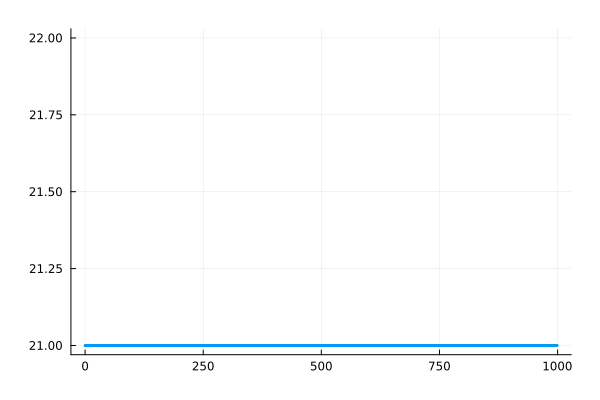

In [4]:
function T_a(t::Float64, t_on::Float64, t_off::Float64)
    return 21 - 5 ./(1+exp(-0.04*(t - t_on))) * exp(-0.05*(t - t_off))./(1+exp(-0.05*(t - t_off)))
end

function T_a(t::Float64)
    return true_τ_a
end

plot(tsteps, T_a.(tsteps))

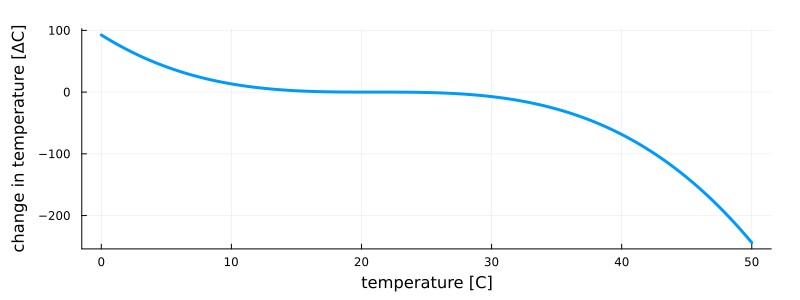

In [5]:
# Nonlinear convection function
r(z,τ_a) = (τ_a - z)^3 ./ 100

τr = range(0., stop=50, step=0.1)
dτr = r.(τr,true_τ_a)

plot(xlabel="temperature [C]", ylabel="change in temperature [ΔC]", size=(800,300))
plot!(τr, dτr)

In [6]:
savefig("figures/designed-nonlinear-convection.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection/experiment-simulated/figures/designed-nonlinear-convection.png"

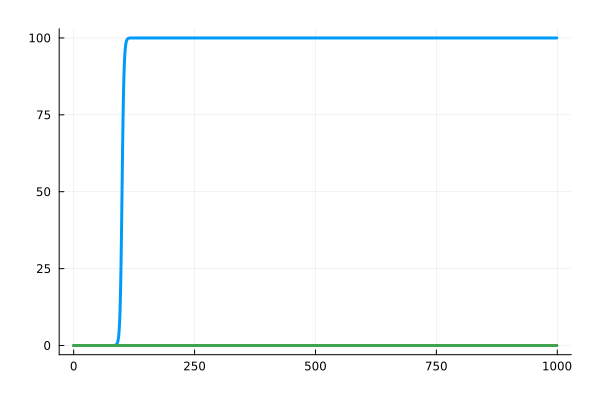

In [7]:
t_onset = 100.
t_offset = 300.
β = 0.5

# Generate functions
u1(t) = u.(t, true_b[1], t_onset, i=1, β=β)
u2(t) = u.(t, true_b[2], t_onset, i=2, β=β)
u3(t) = u.(t, true_b[3], t_onset, i=3, β=β)
  
inputs = hcat([[u1(k); u2(k); u3(k)] for k in tsteps]...)

plot(tsteps, inputs')

In [8]:
function NONLCONV(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (T_a(t) - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (T_a(t) - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (T_a(t) - z[3]) / mcp_3 
    
    # Convection - nonlinear
    dz[1] += r(z[1],T_a(t)) / mcp_1
    dz[2] += r(z[2],T_a(t)) / mcp_2
    dz[3] += r(z[3],T_a(t)) / mcp_3
    
    # Input heat
    dz[1] += u1(t) / mcp_1
    dz[2] += u2(t) / mcp_2
    dz[3] += u3(t) / mcp_3
end

NONLCONV (generic function with 1 method)

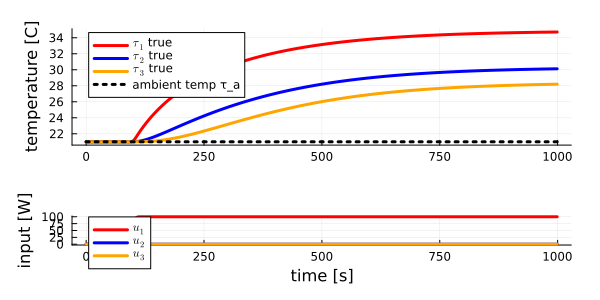

In [9]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3,
             true_k12, 
             true_k23, 
             true_h_a]

τ_0 = [21., 21., 21.]

# Solve the system numerically using DifferentialEquations.jl
sys_NONLCONV = ODEProblem(NONLCONV, τ_0, (tsteps[1], tsteps[end]), sysparams)
states = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps, verbose = true))

# Noisy measurements
measurements = zeros(3,T)
for k = 1:T
    measurements[:,k] = states[:,k] + cholesky(true_R).L*randn(3)
end

p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps, states', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
plot!(tsteps, T_a.(tsteps), color="black", linewidth=3, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [W]")
plot!(tsteps, inputs', linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(600,300))

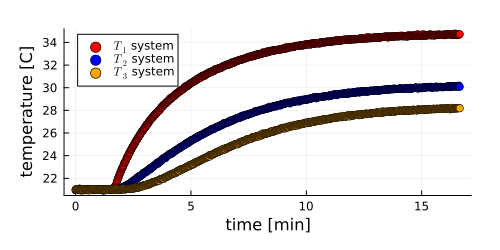

In [10]:
plot(tsteps ./ 60,
     states';
     legend = true, 
     linewidth=4,
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     xlabel = "time [min]", 
     ylabel = "temperature [C]",
     size=(500,250)
)
scatter!(tsteps ./ 60, 
      transpose(measurements), 
      linewidth=4,
      alpha = 1.,
      markercolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$T_1$ system" L"$T_2$ system" L"$T_3$ system"],
)


In [11]:
output_ = [measurements[:,k] for k in 1:T];
inputs_ = [[true_τ_a; inputs[:,k]] for k in 1:T];

## GP-augmented state-space model

### Matern-1/2 GP in state-space form
Suppose a function $h(x)$ follows a zero-mean Gaussian Process

$$\begin{aligned}
h(x) \sim \mathcal{GP}(0, k(x,x')) \, .
\end{aligned}$$

The GP can be written as the following differential equation ([Hartikainen, 2013)](https://aaltodoc.aalto.fi/bitstream/handle/123456789/7579/isbn9789526049847.pdf?sequence=1&isAllowed=y)):

$$\begin{align}
\dot{h} = F_h h + L v \, ,
\end{align}$$

with $h$ being states, $F_h$ a state transition matrix and $v$ a white noise process. The Matern GP has a stationary covariance function, defined as:

$$\begin{aligned}
k(\tau) = \sigma^2 \frac{2^{1-\nu}}{\Gamma(\nu)} \left(\frac{\sqrt{2\nu}\tau}{l} \right)^\nu K_\nu\left(\frac{\sqrt{2\nu}\tau}{l} \right)
\end{aligned}$$

where $\sigma^2$ is a scale hyperparameter, $l$ a characteristic length-scale, $\nu$ the smoothness hyperparameter, and $K_\nu(.)$ is a modified Bessel function of the second kind. 

Matern-1/2 refers to $\nu=1/2$. The matrices for the state space model are computed as follows:

$$\begin{aligned}
\mathbf{F}_h = -\lambda,\quad \quad \mathbf{L} = 1, \quad \quad \mathbf{P}_\infty = \sigma^2  ,\quad \quad  Q_c = 2\lambda\sigma^2
\end{aligned}$$ 

where $\lambda = \frac{\sqrt{3}}{l} $.

### Augmented state-space model

The original state-space model (see top) is:

$$\begin{aligned}
\underbrace{\begin{bmatrix} \dot{\tau}_1 \\ \vdots \\ \dot{\tau}_3 \end{bmatrix}}_{\dot{z}} = \underbrace{\begin{bmatrix} \frac{-k_{12} - h_a a_1}{m_1 c_{p,1}} & \frac{k_{12}}{m_1 c_{p,1}} & 0 \\
\frac{k_{12}}{m_2 c_{p,2}} & \frac{-k_{12} - k_{23} - h_a a_2}{m_2 c_{p,2}} & \frac{k_{23}}{m_2 c_{p,2}} \\
 0 & \frac{k_{23}}{m_3 c_{p,3}} & \frac{-k_{23} - h_a a_3}{m_3 c_{p,3}} \end{bmatrix}}_{F} \underbrace{\begin{bmatrix} \tau_1 \\ \vdots \\ \tau_3 \end{bmatrix}}_{z} + \underbrace{\begin{bmatrix} \frac{h_a a_1}{m_1 c_{p,1}} & \frac{1}{m_1 c_{p,1}} & 0 & 0 \\ \frac{h_a a_2}{m_2 c_{p,2}} & 0 & \frac{1}{m_2 c_{p,2}} & 0 \\ \frac{h_a a_3}{m_3 c_{p,3}} & 0 & 0 & \frac{1}{m_3 c_{p,3}} \end{bmatrix}}_{G} \underbrace{\begin{bmatrix} \tau_a \\ u_1 \\ u_2 \\ u_3 \end{bmatrix}}_{u} + M^{-1}r(z) \, 
\end{aligned}$$

Since $r(z)$ is vector-valued, we need multiple GP functions:

$$\begin{aligned}
r(z) \approx h = \begin{bmatrix} h^{(1)} \\ h^{(2)} \\ h^{(3)} \end{bmatrix} \, .
\end{aligned}$$

Augmenting the state-space model with $h$ as described above, gives:

$$\begin{aligned}
\begin{bmatrix} \dot{z} \\ \dot{h} \end{bmatrix} = \begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix} \begin{bmatrix} z \\ h \end{bmatrix} +  \begin{bmatrix} G \\ 0 \end{bmatrix} u + \begin{bmatrix} 0 \\ L \end{bmatrix} w \, .
\end{aligned}$$

After discretization, we get:

$$\begin{aligned}
x_{k+1} = A x_k + B u_k + w_k\, , \quad \text{with}\ w_k \sim \mathcal{N}(0, Q) \, ,
\end{aligned}$$

where $x_k = \begin{bmatrix} z_k \\ h_k \end{bmatrix}$ and

$$\begin{aligned}
    A = \exp\big(\Delta t \begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix} \big) \, , \quad B = \begin{bmatrix} \Delta t G \\ 0 \end{bmatrix} \, , \quad Q = \int_0^{\Delta t} \exp(\begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix}t) \begin{bmatrix} 0 \\ L \end{bmatrix} Q_c \begin{bmatrix} 0 \\ L \end{bmatrix}^{\top} \exp(\begin{bmatrix} F & M^{-1} \\ 0 & F_h \end{bmatrix} t)^{\top} dt \, .
\end{aligned}$$

In [12]:
@model function SSM(y,u, A, B, C, Q, R, m0, S0, T)
    
    x_0 ~ MvNormalMeanCovariance(m0, S0)
    x_kmin1 = x_0
    for k = 1:T
        
        x[k] ~ MvNormalMeanCovariance(A*x_kmin1 + B*u[k], Q)
        y[k] ~ MvNormalMeanCovariance(C*x[k], R)
        
        x_kmin1 = x[k]
    end
end

In [13]:
Dx = 6
Dt = 3
Dh = 3
Du = 4
Dy = 3

M  = [true_mcp_1          0           0;
     0           true_mcp_2           0;
     0                    0  true_mcp_3]
K  = [-true_k12       true_k12                0;
       true_k12  -(true_k12+true_k23)  true_k23;
              0       true_k23        -true_k23]
An = [true_a_1, true_a_2, true_a_3]

F  = inv(M)*(K - true_h_a*diagm(An))
G  = inv(M)*[true_h_a*An diagm(ones(Dh))]

λ_star = 1.0
γ_star = 1.0

A  = exp([F                              inv(M);
          zeros(Dh,Dh)  diagm(-λ_star*ones(Dh))]*Δt)
B  = [G; zeros(Dh,Du)]*Δt
C  = [diagm(ones(Dy)) zeros(Dy,Dx-Dy)]
Q  = analyticQ(inv(M), λ_star, γ_star, Δt=Δt)
R  = true_R*diagm(ones(Dy))

m0 = [τ_0; zeros(Dh)]
S0 = diagm([ones(Dy); γ_star^2*ones(Dh)])

results = infer(
    model       = SSM(A=A, B=B, C=C, Q=Q, R=R, m0=m0, S0=S0, T=T),
    data        = (y = output_, u = inputs_),
    options     = (limit_stack_depth = 100,),
    free_energy = true,
)

Inference results:
  Posteriors       | available for (x_0, x)
  Free Energy:     | Real[-5224.81]


In [14]:
# Kernel hyperparameter priors
α_l = 5.
β_l = 0.1
α_γ = 5.
β_γ = 0.1

prior_l = GammaShapeRate(α_l, β_l)
prior_γ = GammaShapeRate(α_γ, β_γ)

[mode(GammaShapeRate(α_l, β_l)) mean(GammaShapeRate(α_l, β_l))  var(GammaShapeRate(α_l, β_l))]

1×3 Matrix{Float64}:
 40.0  50.0  500.0

In [15]:
function J(hparams::AbstractVector)

    λ = sqrt(3)/hparams[1]
    A = [inv(M)*(K-true_h_a*diagm(An))              inv(M);
         zeros(Dh,Dh)                   -λ*diagm(ones(Dh))]*Δt + diagm(ones(Dx))
        
    Q = analyticQ(inv(M), λ, hparams[2], Δt=Δt)
        
    m0 = [τ_0; zeros(3)]
    S0 = diagm([1e-3ones(3); hparams[2]^2*ones(3)])

    results = infer(
        model       = SSM(A=A, B=B, C=C, Q=Q, R=R, m0=m0, S0=S0, T=T),
        data        = (y = output_, u = inputs_),
        options     = (limit_stack_depth = 100,),
        free_energy = true,
    )

    return results.free_energy[end] - logpdf(prior_l, hparams[1]) -logpdf(prior_γ, hparams[2])
end

J (generic function with 1 method)

In [16]:
# ops = Optim.Options(f_tol=1e-3, g_tol=1e-3, time_limit=60, show_every=1)
# res = optimize(J, 1e0, 1e6, [10., 10.], Fminbox(LBFGS()), ops; autodiff=:forward)
# l_star, γ_star = Optim.minimizer(res)

l_star = 1423.21
γ_star = 20.345

20.345

In [17]:
λ_star = sqrt(3)/l_star
A = exp([inv(M)*(K - true_h_a*diagm(An))                  inv(M);
         zeros(Dh,Dh)                  -λ_star*diagm(ones(Dh))]*Δt)
Q = analyticQ(inv(M), λ_star, γ_star, Δt=Δt)

m0 = [τ_0; zeros(Dh)]
S0 = diagm([ones(Dt); γ_star^2*ones(Dh)])

results = infer(
        model       = SSM(A=A, B=B, C=C, Q=Q, R=R, m0=m0, S0=S0, T=T),
        data        = (y = output_, u = inputs_),
        options     = (limit_stack_depth = 100,),
        free_energy = true,
    )

Inference results:
  Posteriors       | available for (x_0, x)
  Free Energy:     | Real[-5591.79]


In [18]:
H = ForwardDiff.jacobian(x -> ForwardDiff.gradient(J, x), [l_star, γ_star])
post_S = inv(Hermitian((H + H')/2))

2×2 Hermitian{Float64, Matrix{Float64}}:
 -2796.89   -174.805
  -174.805    -3.50829

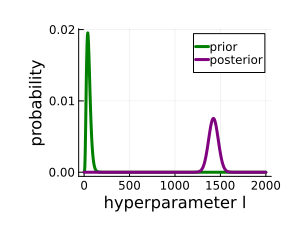

In [19]:
lr = range(1e-3, stop=2e3, length=500)
post_l = NormalMeanVariance(l_star, abs(post_S[1,1]))

p401 = plot(legend=:topright, ylabel="probability", xlabel="hyperparameter l", size=(300,240), yticks=[0., 0.01, 0.02])
plot!(lr, pdf.(prior_l, lr), color="green", label="prior")
plot!(lr, pdf.(post_l, lr), color="purple", label="posterior")

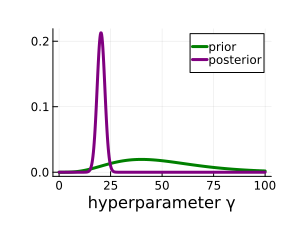

In [20]:
γr = range(1e-2, stop=1e2, length=500)
post_γ = NormalMeanVariance(γ_star, abs(post_S[2,2]))

p402 = plot(legend=:topright, ylabel="", xlabel="hyperparameter γ", size=(300,240), yticks=[0., 0.1, 0.2])
plot!(γr, pdf.(prior_γ, γr), color="green", label="prior")
plot!(γr, pdf.(post_γ, γr), color="purple", label="posterior")

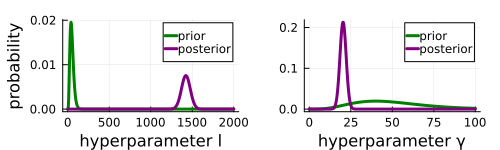

In [21]:
plot(p401,p402, layout=(1,2), size=(500,150), margin=3.0Plots.mm)

In [22]:
savefig("figures/hparams-estimated.png")

"/home/wmkouw/syndr/Wouter/Onderzoek/Projecten/sioux/sysid-thermal/CCTA2024-BIDconvection/experiment-simulated/figures/hparams-estimated.png"

In [23]:
qx = results.posteriors[:x]
fitx_v = cat( var.(qx)..., dims=2)
fitx_m = cat(mean.(qx)..., dims=2)

6×1000 Matrix{Float64}:
 20.9722    20.981     20.9826    …   34.7036    34.7123    34.7173
 20.9861    20.9993    20.999         30.139     30.1163    30.1088
 21.001     21.0011    21.0047        28.1976    28.1911    28.1887
  1.55777    1.54917    1.53037      -26.0132   -25.9599   -25.9228
  0.956387   0.939584   0.906122      -7.87808   -7.92457   -7.92639
 -0.156174  -0.157152  -0.164301  …   -4.17329   -4.18859   -4.18815

In [24]:
SMSE_GPSSM = mean((fitx_m[1:3,:] - states).^2)
println("MSE states and fit: $SMSE_GPSSM")

MSE states and fit: 0.00017111150644704773


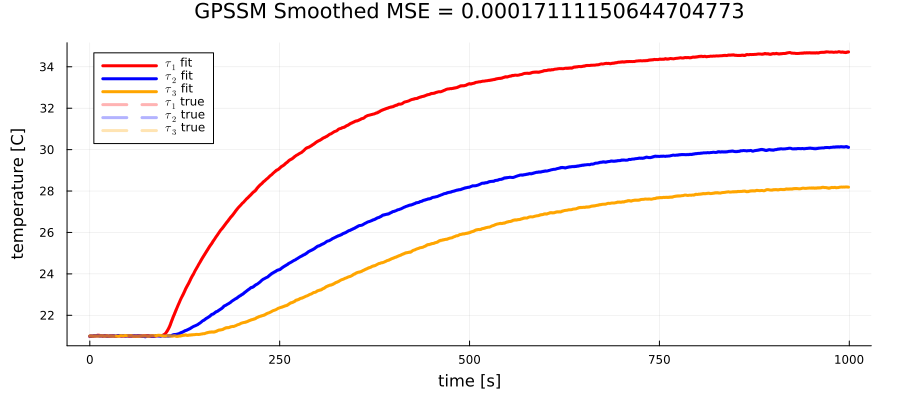

In [25]:
plot(tsteps,
     fitx_m[1:3,:]';
     ribbon=sqrt.(fitx_v[1:3,:])',
     legend = true, 
     title="GPSSM Smoothed MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ fit" L"$τ_2$ fit" L"$τ_3$ fit"],
     xlabel = "time [s]", 
     ylabel = "temperature [C]",
     size=(900,400)
)
plot!(tsteps, 
      transpose(states), 
      alpha = 0.3,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
)


### Gaussian process fits over time

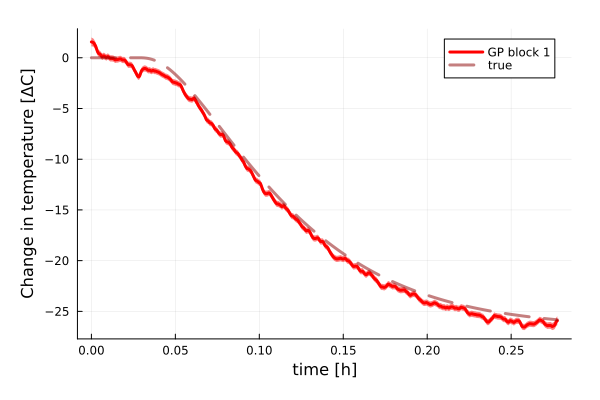

In [26]:
plot(tsteps ./ 3600,
     fitx_m[4,:];
     ribbon=sqrt.(fitx_v[4,:])./10,
     legend = true, 
     color = "red",
     labels = "GP block 1",
     xlabel = "time [h]", 
     ylabel = "Change in temperature [ΔC]",
     size=(600,400)
)
plot!(tsteps ./ 3600, r.(states[1,:], true_τ_a), color="darkred", alpha=0.5, linestyle=:dash, label="true")
# plot!(tsteps, r.(states[1,:],1,true_τ_a), color="darkred", alpha=0.5, linestyle=:dash, label="true")

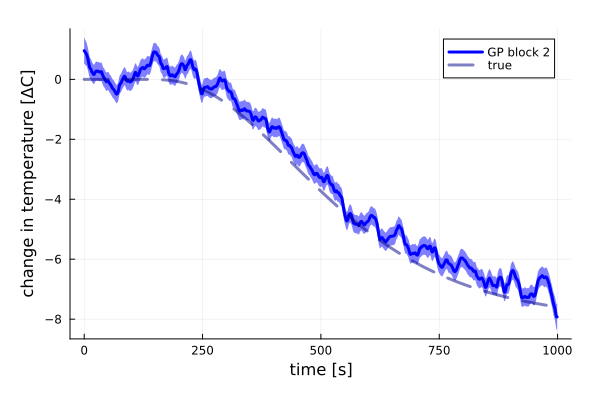

In [27]:
plot(tsteps,
     fitx_m[5,:],
     ribbon=sqrt.(fitx_v[5,:])./10,
     legend = true, 
     color = "blue",
     labels = "GP block 2",
     xlabel = "time [s]", 
     ylabel = "change in temperature [ΔC]",
     size=(600,400)
)
plot!(tsteps, r.(states[2,:], true_τ_a), color="darkblue", alpha=0.5, linestyle=:dash, label="true")

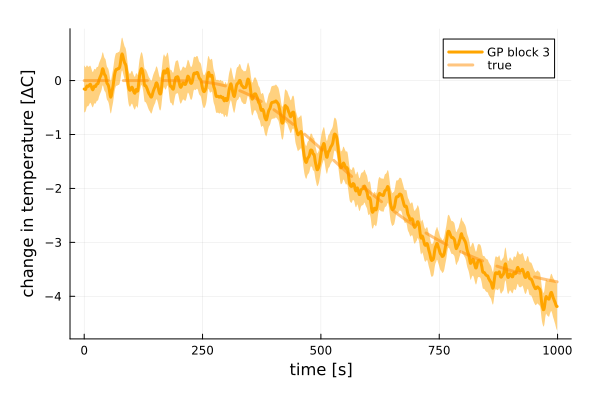

In [28]:
plot(tsteps,
     fitx_m[6,:],
     ribbon=sqrt.(fitx_v[6,:]) ./ 10,
     legend = true, 
     color = "orange",
     labels = "GP block 3",
     xlabel = "time [s]", 
     ylabel = "change in temperature [ΔC]",
     size=(600,400)
)
plot!(tsteps, r.(states[3,:], true_τ_a), color="darkorange", alpha=0.5, linestyle=:dash, label="true")

### Extract nonlinearity

In [29]:
# Define basis function
deg = 3
ϕ(x; deg=3) = [x^d for d in 0:deg]

# Compute posterior coefficients
function postcoeffs(y_m, x_m, x_v, ϕ,μ0,Σ0; deg=3, T=1)

    if length(x_v) == 1; x_v = x_v*ones(length(x_m)); end

    tmp1 = zeros(deg+1)
    tmp2 = zeros(deg+1,deg+1)
    for k = 1:T
        ϕk = ϕ(x_m[k], deg=deg)
        tmp1 += ϕk*inv(x_v[k])*y_m[k]
        tmp2 += inv(x_v[k])*ϕk*ϕk'
    end
    Σ = inv(inv(Σ0) + tmp2)
    μ = Σ*(inv(Σ0)*μ0 + tmp1)
    return μ,Σ
end

postcoeffs (generic function with 1 method)

In [30]:
# Prior coefficients
μ10 = zeros(deg+1)
Σ10 = 1e3diagm(ones(deg+1))

# Posterior coefficients
σ2 = mean(fitx_v[4,:])
μ1,Σ1 = postcoeffs(fitx_m[4,:], fitx_m[1,:], σ2, ϕ, μ10, Σ10, deg=deg, T=T)

# Predicted function
ρ1_m = [μ1'*ϕ.(fitx_m[1,k], deg=deg) for k in 1:T]
ρ1_s = sqrt.([ϕ.(fitx_m[1,k], deg=deg)'*Σ1*ϕ.(fitx_m[1,k], deg=deg) + σ2 for k in 1:T]);

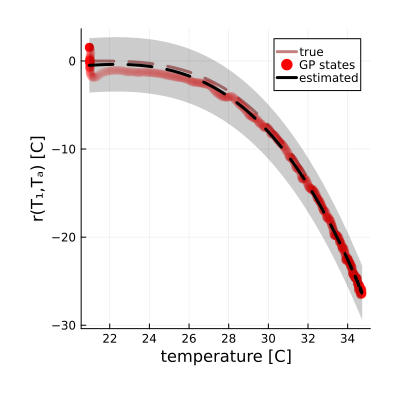

In [31]:
plot(xlabel="temperature [C]",
     ylabel="r(T₁,Tₐ) [C]",
     size=(400,400),
     )
plot!(states[1,:], r.(states[1,:],true_τ_a), color="darkred", linestyle=:dash, alpha=0.5, label="true")
scatter!([fitx_m[1,1]], [fitx_m[4,1]], alpha=1, label="GP states", markerstrokewidth=0, markersize=5, color="red")
scatter!(fitx_m[1,2:end], fitx_m[4,2:end], alpha=0.1, markerstrokewidth=0, markersize=5, color="red")
plot!(sort(fitx_m[1,:]), ρ1_m, ribbon=ρ1_s, color="black", fillalpha=0.2, linestyle=:dash, label="estimated")

In [32]:
# Prior coefficients
μ20 = zeros(deg+1)
Σ20 = 1e3diagm(ones(deg+1))

# Posterior coefficients
μ2,Σ2 = postcoeffs(fitx_m[5,:], fitx_m[2,:], mean(fitx_v[5,:]), ϕ, μ20, Σ20, deg=deg, T=T)

# Predicted function
ρ2_m = [μ2'*ϕ.(fitx_m[2,k], deg=deg) for k in 1:T]
ρ2_s = sqrt.([ϕ.(fitx_m[2,k], deg=deg)'*Σ2*ϕ.(fitx_m[2,k], deg=deg) + mean(fitx_v[5,k]) for k in 1:T]);

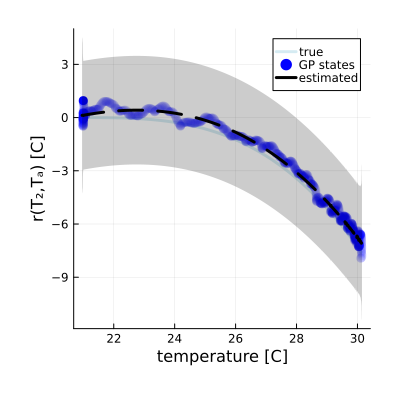

In [33]:
plot(xlabel="temperature [C]",
     ylabel="r(T₂,Tₐ) [C]",
     size=(400,400),
     )
plot!(states[2,:], r.(states[2,:],true_τ_a), color="lightblue", linestyle=:solid, alpha=0.5, label="true")
scatter!([fitx_m[2,2]], [fitx_m[5,1]], alpha=1, label="GP states", markerstrokewidth=0, markersize=5, color="blue")
scatter!(fitx_m[2,2:end], fitx_m[5,2:end], alpha=0.1, markerstrokewidth=0, markersize=5, color="blue")
plot!(sort(fitx_m[2,:]), ρ2_m, ribbon=ρ2_s, color="black", fillalpha=0.2, linestyle=:dash, label="estimated")

In [34]:
# Prior coefficients
μ30 = zeros(deg+1)
Σ30 = 1e3diagm(ones(deg+1))

# Posterior coefficients
μ3,Σ3 = postcoeffs(fitx_m[6,:], fitx_m[3,:], mean(fitx_v[3,:]), ϕ, μ30, Σ30, deg=deg, T=T)

# Predicted function
ρ3_m = [μ3'*ϕ.(fitx_m[3,k], deg=deg) for k in 1:T]
ρ3_s = sqrt.([ϕ.(fitx_m[3,k], deg=deg)'*Σ3*ϕ.(fitx_m[3,k], deg=deg) + mean(fitx_v[6,k]) for k in 1:T]);

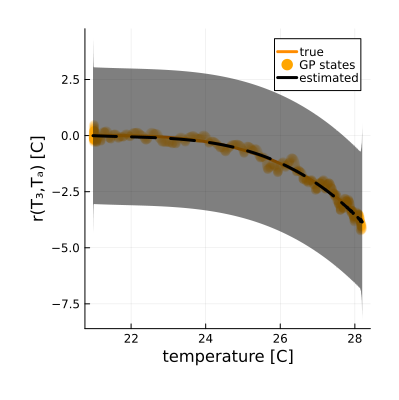

In [35]:
plot(xlabel="temperature [C]",
     ylabel="r(T₃,Tₐ) [C]",
     size=(400,400),
     )
plot!(states[3,:], r.(states[3,:],true_τ_a), color="darkorange", linestyle=:solid, alpha=1., label="true")
scatter!([fitx_m[3,3]], [fitx_m[6,1]], alpha=1, label="GP states", markerstrokewidth=0, markersize=5, color="orange")
scatter!(fitx_m[3,2:end], fitx_m[6,2:end], alpha=0.1, markerstrokewidth=0, markersize=5, color="orange")
plot!(sort(fitx_m[3,:]), ρ3_m, ribbon=ρ3_s, color="black", fillalpha=0.5, linestyle=:dash, label="estimated")

## Model validation

### Simulation with true function to generate validation data

In [36]:
N_val = 1000
tsteps_val = range(0.0, step=Δt, length=N_val)

t_onset_val = 120.
t_offset_val = 600.
β = 0.5

# Generate functions
# u1(t) = u.(t, b=true_b[1], t_on=t_onset, t_off=t_offset, i=1, β1=β)
u1_val(t) = u.(t, b=true_b[1], t_on=t_onset_val, t_off=t_offset_val, i=1, β1=β)
u2_val(t) = u.(t, b=true_b[2], t_on=t_onset_val, t_off=t_offset_val, i=2, β1=β)
u3_val(t) = u.(t, b=true_b[3], t_on=t_onset_val, t_off=t_offset_val, i=3, β1=β)

inputs_val = hcat([[u1_val(k); u2_val(k); u3_val(k)] for k in tsteps_val]...)

3×1000 Matrix{Float64}:
 8.75651e-25  1.4437e-24  2.38027e-24  3.9244e-24  …  7.24967e-68  4.8596e-68
 0.0          0.0         0.0          0.0            0.0          0.0
 0.0          0.0         0.0          0.0            0.0          0.0

In [37]:
function NONLCONV_val(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += r(z[1],τ_a) ./ mcp_1
    dz[2] += r(z[2],τ_a) ./ mcp_2
    dz[3] += r(z[3],τ_a) ./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

NONLCONV_val (generic function with 1 method)

In [38]:
sysparams = [true_mcp_1, 
             true_mcp_2, 
             true_mcp_3, 
             true_a_1, 
             true_a_2, 
             true_a_3, 
             true_τ_a, 
             true_k12, 
             true_k23, 
             true_h_a]

τ0_val = [25., 25., 25.]
sys_NONLCONV = ODEProblem(NONLCONV_val, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
states_val = Array(solve(sys_NONLCONV, RK4(); saveat=tsteps_val, verbose = true))

measurements_val = states_val + cholesky(true_R).L*randn(size(states_val))

3×1000 Matrix{Float64}:
 25.028   24.9656  24.9606  24.9472  …  24.6495  24.6698  24.6594  24.6649
 25.0422  24.9833  24.9769  24.9829     24.6004  24.6178  24.5909  24.5923
 24.9975  25.053   24.9973  24.9764     24.5752  24.6493  24.5692  24.5634

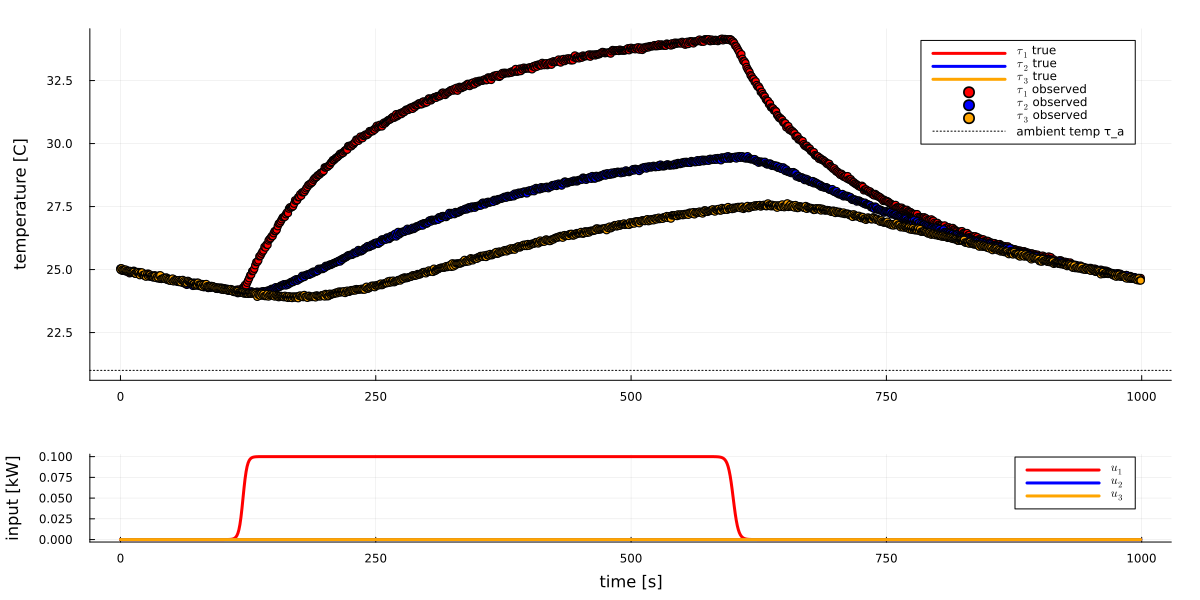

In [39]:
p101 = plot(xlabel="", ylabel="temperature [C]")
plot!(tsteps_val, states_val', linecolors = ["red" "blue" "orange"], labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"], )
scatter!(tsteps_val, measurements_val', markercolors = ["red" "blue" "orange"], labels = [L"$τ_1$ observed" L"$τ_2$ observed" L"$τ_3$ observed"])
hline!([true_τ_a], color="black", linewidth=1, linestyle=:dot, label="ambient temp τ_a")

p102 = plot(xlabel = "time [s]", ylabel = "input [kW]")
plot!(tsteps_val, inputs_val' ./ 1000, linecolors = ["red" "blue" "orange"], labels = [L"$u_1$" L"$u_2$" L"$u_3$"], )

plot(p101, p102, layout=grid(2,1, heights=[0.8, 0.2]), size=(1200,600))

### Simulation by identified model

In [43]:
function NONLCONV_idsim(dz, z, params, t)
    "Lumped-element model with nonlinear convection term"

    # Extract parameters
    mcp_1, mcp_2, mcp_3, a_1, a_2, a_3, τ_a, k12, k23, h_a = params
    
    # Conduction
    dz[1] = (-k12*z[1] +      k12 *z[2]            ) / mcp_1
    dz[2] = ( k12*z[1] - (k12+k23)*z[2] + k23 *z[3]) / mcp_2
    dz[3] = (                 k23 *z[2] - k23 *z[3]) / mcp_3
    
    # Convection - linear
    dz[1] += h_a * a_1 * (τ_a - z[1]) / mcp_1
    dz[2] += h_a * a_2 * (τ_a - z[2]) / mcp_2
    dz[3] += h_a * a_3 * (τ_a - z[3]) / mcp_3
    
    # Convection - nonlinear
    dz[1] += μ1'*ϕ(z[1]) ./ mcp_1
    dz[2] += μ2'*ϕ(z[2]) ./ mcp_2
    dz[3] += μ3'*ϕ(z[3]) ./ mcp_3
    
    # Input heat
    dz[1] += u1_val(t) / mcp_1
    dz[2] += u2_val(t) / mcp_2
    dz[3] += u3_val(t) / mcp_3
end

idNONLCONV = ODEProblem(NONLCONV_idsim, τ0_val, (tsteps_val[1], tsteps_val[end]), sysparams)
sim_states = Array(solve(idNONLCONV, RK4(); saveat=tsteps_val, verbose = true))

3×1000 Matrix{Float64}:
 25.0  24.991   24.982   24.9731  …  24.6132  24.6053  24.5975  24.5896
 25.0  24.9918  24.9837  24.9756     24.632   24.6244  24.6167  24.6091
 25.0  24.9914  24.9828  24.9742     24.6094  24.6019  24.5945  24.587

### Compare true and identified 

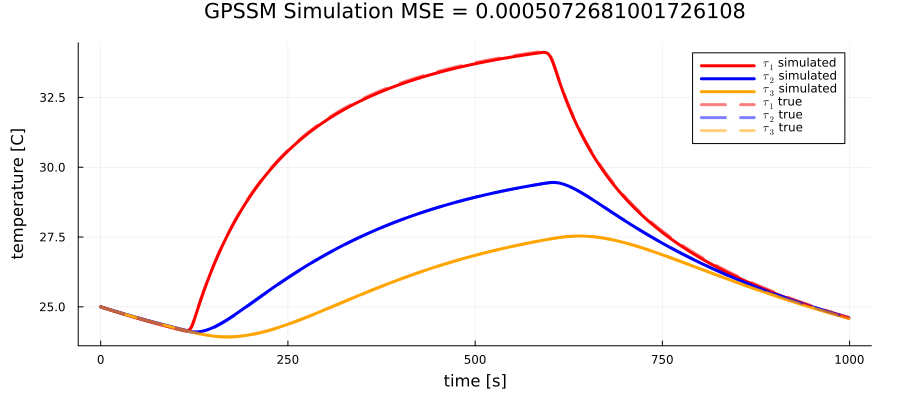

In [44]:
SMSE_GPSSM = mean((sim_states - states_val).^2)

plot(tsteps_val,
     sim_states';
     legend = true, 
     title = "GPSSM Simulation MSE = $SMSE_GPSSM",
     linecolors = ["red" "blue" "orange"], 
     fillcolors = ["red" "blue" "orange"], 
     labels = [L"$τ_1$ simulated" L"$τ_2$ simulated" L"$τ_3$ simulated"],
     xlabel = "time [s]", 
     ylabel = "temperature [C]",
     size=(900,400)
)
plot!(tsteps_val, 
      transpose(states_val), 
      alpha = 0.5,
      linecolors = ["red" "blue" "orange"], 
      linestyle = :dash,
      labels = [L"$τ_1$ true" L"$τ_2$ true" L"$τ_3$ true"],
)


In [45]:
jldsave("results/LGPASSM.jld2"; true_mcp_1, true_mcp_2, true_mcp_3, true_τ_a, tsteps, Δt, fitx_m, fitx_v, states, measurements, inputs, μ1,Σ1, μ2,Σ2, μ3,Σ3, ρ1_m,ρ1_s, ρ2_m,ρ2_s, ρ3_m,ρ3_s, l_star, γ_star, tsteps_val, sim_states, states_val)